In [1]:
import getpass
import importlib.resources
import json
import os
import subprocess
from typing import Any, Dict, List, TypedDict

from google.cloud import pubsub_v1
from langchain.chat_models import init_chat_model
from langchain.tools import BaseTool, Tool, tool
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langchain_google_community import GmailToolkit
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

In [2]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")
_set_env("OPENAI_API_KEY")
_set_env("GOOGLE_APPLICATION_CREDENTIALS")

----
## Workarena task config(s) tools

Specifically entailing to the task-type: `Order`

In [3]:
def infer_schema(data_list):
    """
    Infers a JSON schema from a list of data elements.

    Args:
        data_list (list): A list of data elements (e.g., dictionaries, lists, or primitives).

    Returns:
        dict or None: A dictionary representing the inferred JSON schema, or None if the input list is empty.

    Raises:
        ValueError: If the data contains mixed types for the same field or an unsupported type.
    """
    if not data_list:
        return None
    first = data_list[0]
    if all(x == first for x in data_list):
        # All values are identical
        return {"const": first}
    else:
        # Values differ; determine common type
        types = set(type(x) for x in data_list)
        if len(types) > 1:
            raise ValueError("Different types for the same field")
        typ = next(iter(types))
        if typ == dict:
            # For dictionaries
            all_keys = set().union(*(d.keys() for d in data_list))
            schema = {"type": "object", "properties": {}}
            for key in all_keys:
                sub_data = [d.get(key) for d in data_list if key in d]
                if sub_data:
                    schema["properties"][key] = infer_schema(sub_data)
            # Add required fields
            required = [key for key in all_keys if all(key in d for d in data_list)]
            if required:
                schema["required"] = required
            return schema
        elif typ == list:
            # For lists
            lengths = set(len(x) for x in data_list)
            if len(lengths) == 1:
                length = next(iter(lengths))
                items_schema = [
                    infer_schema([x[i] for x in data_list]) for i in range(length)
                ]
                return {"type": "array", "items": items_schema}
            else:
                # Variable length; use general array schema
                all_elements = [item for sublist in data_list for item in sublist]
                if all_elements:
                    return {"type": "array", "items": infer_schema(all_elements)}
                else:
                    return {"type": "array", "items": {}}
        elif typ in (str, int, float, bool):
            # For primitives
            return {"type": typ.__name__}
        else:
            raise ValueError("Unsupported type")


def infer_dict_schema(file_path):
    """
    Infers a JSON schema from a JSON file containing a list of dictionaries.

    Args:
        file_path (str): Path to the JSON file.

    Returns:
        dict: A dictionary representing the inferred JSON schema.

    Raises:
        ValueError: If the file does not contain a list of dictionaries.
        FileNotFoundError: If the specified file path does not exist.
        json.JSONDecodeError: If the file contains invalid JSON.
    """
    with open(file_path, "r") as f:
        data = json.load(f)
    if isinstance(data, list) and all(isinstance(item, dict) for item in data):
        return infer_schema(data)
    else:
        raise ValueError("File must contain a list of dictionaries")


def get_available_task_configs() -> List[str]:
    """List all available task configuration files.

    Returns:
        List[str]: List of task configs.
    """
    package = "browsergym.workarena.data_files.task_configs"

    try:
        # Using files() instead of contents() to avoid deprecation warning
        files = [
            f.name
            for f in importlib.resources.files(package).iterdir()
            if f.name.endswith(".json") and f.name.startswith("order_")
        ]
        return files
    except ImportError:
        print(f"Error: Could not import package '{package}'")
        return []


def _get_available_task_names() -> List[str]:
    """
    Returns a list of available task names without the '.json' extension.

    Returns:
        List[str]: List of task names.
    """
    package = "browsergym.workarena.data_files.task_configs"

    try:
        files = [
            f.name[:-5]  # Remove '.json' extension
            for f in importlib.resources.files(package).iterdir()
            if f.name.endswith(".json") and f.name.startswith("order_")
        ]
        return files
    except ImportError:
        print(f"Error: Could not import package '{package}'")
        return []


def _get_task_config_schema(task_name: str) -> Dict[str, Any]:
    """
    Retrieves the JSON schema for a given task configuration.

    Args:
        task_name (str): Name of the task (e.g., 'order_ipad_mini_task').

    Returns:
        Dict[str, Any]: The inferred JSON schema for the task configuration.

    Raises:
        ValueError: If the task name is invalid or not found.
        FileNotFoundError: If the JSON file cannot be accessed.
        json.JSONDecodeError: If the JSON file is invalid.
    """
    package = "browsergym.workarena.data_files.task_configs"

    available_tasks = _get_available_task_names()
    if task_name not in available_tasks:
        raise ValueError(
            f"Invalid task name: {task_name}. Available tasks are: {', '.join(available_tasks)}"
        )

    json_file_name = f"{task_name}.json"
    try:
        with importlib.resources.as_file(
            importlib.resources.files(package).joinpath(json_file_name)
        ) as file_path:
            with open(file_path, "r") as f:
                data = json.load(f)
    except FileNotFoundError:
        raise FileNotFoundError(f"Configuration file for task '{task_name}' not found.")
    except json.JSONDecodeError:
        raise json.JSONDecodeError(
            f"Invalid JSON in configuration file for task '{task_name}'."
        )

    if isinstance(data, list) and all(isinstance(item, dict) for item in data):
        return infer_schema(data)
    else:
        raise ValueError(
            f"Configuration file for task '{task_name}' must contain a list of dictionaries."
        )

In [4]:
def _get_task_config_example(task_name: str) -> Dict[str, Any]:
    """
    Retrieves a randomly sampled example from a task configuration.

    Args:
        task_name (str): Name of the task (e.g., 'order_ipad_mini_task').

    Returns:
        Dict[str, Any]: A randomly selected example from the task configuration.

    Raises:
        ValueError: If the task name is invalid, not found, or the configuration is invalid.
        FileNotFoundError: If the JSON file cannot be accessed.
        json.JSONDecodeError: If the JSON file is invalid.
    """
    import random

    package = "browsergym.workarena.data_files.task_configs"

    available_tasks = _get_available_task_names()
    if task_name not in available_tasks:
        raise ValueError(
            f"Invalid task name: {task_name}. Available tasks are: {', '.join(available_tasks)}"
        )

    json_file_name = f"{task_name}.json"
    try:
        with importlib.resources.as_file(
            importlib.resources.files(package).joinpath(json_file_name)
        ) as file_path:
            with open(file_path, "r") as f:
                data = json.load(f)
    except FileNotFoundError:
        raise FileNotFoundError(f"Configuration file for task '{task_name}' not found.")
    except json.JSONDecodeError:
        raise json.JSONDecodeError(
            f"Invalid JSON in configuration file for task '{task_name}'."
        )

    if isinstance(data, list) and all(isinstance(item, dict) for item in data):
        if not data:
            raise ValueError(f"Configuration file for task '{task_name}' is empty.")
        return random.choice(data)
    else:
        raise ValueError(
            f"Configuration file for task '{task_name}' must contain a list of dictionaries."
        )

In [5]:
@tool
def get_available_task_names() -> str:
    """
    Retrieves a JSON list of all available task names that can be executed on the ServiceNow platform,
    such as 'order_ipad_mini_task'. Use this to verify or discover valid task names.

    Returns:
        str: JSON string with task names or an error message.
    """
    try:
        task_names = _get_available_task_names()
        return json.dumps(task_names)
    except Exception as e:
        return json.dumps({"error": str(e)})

In [6]:
@tool
def get_task_config_schema(task_name: str) -> str:
    """
    Retrieves the JSON schema for a given task’s configuration, defining required fields (e.g., quantity, color).
    Input is the task name (e.g., 'order_ipad_mini_task').

    Args:
        task_name (str): Name of the task.

    Returns:
        str: JSON string with the schema or an error message.
    """
    try:
        schema = _get_task_config_schema(task_name)
        return json.dumps(schema)
    except Exception as e:
        return json.dumps({"error": str(e)})

In [7]:
@tool
def get_task_config_example(task_name: str) -> str:
    """
    Retrieves a randomly sampled example from a given task’s configuration (e.g., a sample order with fields like quantity, color).
    Input is the task name (e.g., 'order_ipad_mini_task').

    Args:
        task_name (str): Name of the task.

    Returns:
        str: JSON string with the example or an error message.
    """
    try:
        example = _get_task_config_example(task_name)
        return json.dumps(example)
    except Exception as e:
        return json.dumps({"error": str(e)})

In [8]:
@tool
def find_task_config_index(task_name: str, config_json: str) -> str:
    """
    Finds the index (config_id) of an exact configuration match in the task’s predefined list.
    Requires a task name and a JSON string of the configuration dictionary.

    Args:
        task_name (str): Name of the task (e.g., 'order_ipad_mini_task').
        config_json (str): JSON string representing the configuration dictionary to search for.

    Returns:
        str: JSON string with the index (e.g., {"index": 2}) or an error message.
    """
    package = "browsergym.workarena.data_files.task_configs"

    try:
        available_tasks = _get_available_task_names()
        if task_name not in available_tasks:
            return json.dumps(
                {
                    "error": f"Invalid task name: {task_name}. Available tasks are: {', '.join(available_tasks)}"
                }
            )

        json_file_name = f"{task_name}.json"
        package = "browsergym.workarena.data_files.task_configs"
        with importlib.resources.as_file(
            importlib.resources.files(package).joinpath(json_file_name)
        ) as file_path:
            with open(file_path, "r") as f:
                data = json.load(f)
        if not isinstance(data, list):
            return json.dumps(
                {
                    "error": f"Configuration file for task '{task_name}' does not contain a list."
                }
            )

        try:
            search_dict = json.loads(config_json)
        except json.JSONDecodeError:
            return json.dumps({"error": "Invalid JSON provided for config_dict."})
        for i, item in enumerate(data):
            if item == search_dict:
                return json.dumps({"index": i})
        return json.dumps(
            {"error": "Configuration not found in the task's configuration list."}
        )

    except Exception as e:
        return json.dumps({"error": str(e)})

---
### Test

In [ ]:
tools = [get_available_task_names, get_task_config_schema, find_task_config_index]

llm = init_chat_model(model="o3-mini-2025-01-31", model_provider="openai")

agent = create_react_agent(llm, tools)

user_message = "Get all available task names and fill the configuration schema for 'ipad-mini' tasks using colour='Space Grey', storage='256' and quantity=1; if the schema has an array, fill only the first non-constant placeholder; return only the completed schema without any extra text. Finally, get the index of the configuration."

events = agent.stream(
    {"messages": [("user", user_message)]},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

---
## GCP & GMAIL tools 

In [9]:
def retrieve_filtered_emails(subscription_name, max_messages=10):
    """Retrieves messages from a Pub/Sub subscription and returns them in a structured format.

    Args:
        subscription_name (str): The full name of the Pub/Sub subscription (e.g., 'projects/{project_id}/subscriptions/{subscription_id}').
        max_messages (int): The maximum number of messages to pull (default is 10).

    Returns:
        list: A list of dictionaries, each containing structured email data.
    """
    # Initialize Pub/Sub subscriber client
    subscriber = pubsub_v1.SubscriberClient()

    # Pull messages from the subscription
    response = subscriber.pull(
        request={"subscription": subscription_name, "max_messages": max_messages}
    )

    emails = []
    ack_ids = []

    for received_message in response.received_messages:
        # Decode and parse the message data
        data = received_message.message.data.decode("utf-8")
        email_data = json.loads(data)

        # Extract headers into a dictionary
        headers = {h["name"]: h["value"] for h in email_data["payload"]["headers"]}

        # Create a structured dictionary for the email
        email = {
            "id": email_data["id"],
            "threadId": email_data["threadId"],
            "subject": headers.get("Subject"),
            "from": headers.get("From"),
            "to": headers.get("To"),
            "date": headers.get("Date"),
            "snippet": email_data.get("snippet"),
        }

        emails.append(email)
        ack_ids.append(received_message.ack_id)

    # Acknowledge the messages--to remove them from the subscription, preventing redelivery.
    if ack_ids:
        subscriber.acknowledge(
            request={"subscription": subscription_name, "ack_ids": ack_ids}
        )

    return emails, ack_ids

In [10]:
@tool
def get_filtered_emails() -> list[dict]:
    """
    Retrieve a list of incoming emails to the Gmail account that have 'Order' or 'Purchase' in their subject line.

    Returns:
        list[dict]: A list of email objects, each containing:
            - id (str): The Gmail message ID
            - threadId (str): The Gmail thread ID
            - subject (str): The email subject
            - from (str): The sender email address
            - to (str): The recipient email address
            - date (str): The email send date and time
            - snippet (str): A short summary of the email content
    """
    subscription_name = (
        "projects/botty-bot-2025-04-09-nidhir/subscriptions/test-filtered-sub"
    )
    emails, _ = retrieve_filtered_emails(subscription_name)
    return emails

In [11]:
gmail_toolkit = GmailToolkit()
gmail_tools = gmail_toolkit.get_tools()

----
### Test

In [ ]:
tools = [get_filtered_emails] + gmail_tools

llm = init_chat_model(model="o3-mini-2025-01-31", model_provider="openai")

agent = create_react_agent(llm, tools)

user_message = "Can you give me the summary of all the Order related emails and reply each of these emails with a message 'Order Recieved'."

events = agent.stream(
    {"messages": [("user", user_message)]},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

---
### MCP 
NOTE: **Errorneous**, get back to this later!

In [ ]:
from langchain_mcp_adapters.tools import load_mcp_tools
from mcp import ClientSession, StdioServerParameters
from mcp.client.stdio import stdio_client

In [ ]:
server_params = StdioServerParameters(
    command="/opt/homebrew/bin/uv",
    args=[
        "--directory",
        "/Users/nidhirbhavsar/Desktop/WORK/mcp/gmail_mcp",
        "run",
        "main.py",
    ],
)

In [ ]:
llm = init_chat_model(model="claude-3-5-sonnet-20241022", model_provider="anthropic")

async with stdio_client(server_params) as (read, write):
    async with ClientSession(read, write) as session:
        # Initialize the connection
        await session.initialize()

        # Get tools
        tools = await load_mcp_tools(session)
        print(tools)
        print("=" * 50)

        # Create and run the agent
        # agent = create_react_agent(model, tools)
        # agent_response = await agent.ainvoke({"messages": "please give me the summary of recent order related emails."})

        print("Agent response:")
        async for chunk in agent.astream(
            {"messages": "please give me the summary of recent order related emails."}
        ):
            # Print each chunk as it arrives (end="" prevents newlines)
            print(chunk, end="", flush=True)
        print()

----
## `run_experiment.sh` as a tool 

In [12]:
@tool
def execute_task(task_name: str, config_id: int) -> Dict[str, str]:
    """
    Executes a specified task on the ServiceNow platform using the provided task_name and config_id.
    This performs actions such as ordering products or other operations, followed by additional processing steps.

    Args:
        task_name (str): The name of the task (e.g., "order_ipad_mini_task").
        config_id (int): The configuration index for the task.

    Returns:
        Dict[str, str]: Contains:
            - 'exp_dir': Directory of results (or None if unavailable).
            - 'status': Outcome ('success', 'task_failed', 'post_processing_failed').
    """
    task_name = "workarena.servicenow." + "-".join(task_name.split("_")[:-1])

    # Default values from the bash script
    model_provider = "anthropic"
    model_name = "claude-3-7-sonnet-20250219"
    max_steps = 15
    visual_effects = "true"
    use_html = "false"
    use_axtree = "true"
    use_screenshot = "false"
    results_dir = "./results"
    agent_type = "workflow"
    system_message = """# Instructions

Review the current state of the page and all other information to find the best
possible next action to accomplish your goal. Your answer will be interpreted
and executed by a program, make sure to follow the formatting instructions.
Do not visit any external websites outside from the servicenow.com domain unless they are provided explicitly."""

    # Determine agent path based on agent type
    agent_path = (
        "agents/workflow_agent/run_demo.py"
        if agent_type == "workflow"
        else "agents/simple_agent/run_demo.py"
    )

    # Step 1: Run the experiment
    experiment_command = [
        "uv",
        "run",
        "--env-file",
        ".env",
        agent_path,
        "--model_provider",
        model_provider,
        "--task_name",
        task_name,
        "--model_name",
        model_name,
        "--max_steps",
        str(max_steps),
        "--visual_effects",
        visual_effects,
        "--use_html",
        use_html,
        "--use_axtree",
        use_axtree,
        "--use_screenshot",
        use_screenshot,
        "--system_message",
        system_message,  # Pass the system message directly
        "--results_dir",
        results_dir,
        "--config_id",
        str(config_id),
    ]

    try:
        process = subprocess.run(
            experiment_command, check=True, capture_output=True, text=True
        )
        exp_dir = None
        for line in process.stdout.splitlines():
            if line.startswith("EXPERIMENT_DIR="):
                exp_dir = line.split("=", 1)[1].strip()
                break
    except subprocess.CalledProcessError as e:
        return {"exp_dir": None, "status": f"experiment_failed: {e.stderr}"}

    # Step 2: Run trace_formatter.py
    trace_formatter_command = [
        "uv",
        "run",
        "--env-file",
        ".env",
        "experiments/logging/trace_formatter.py",
        "--results_dir",
        results_dir,
        "--system_message",
        system_message,
    ]

    try:
        subprocess.run(
            trace_formatter_command, check=True, capture_output=True, text=True
        )
    except subprocess.CalledProcessError as e:
        return {"exp_dir": exp_dir, "status": f"trace_formatter_failed: {e.stderr}"}

    # Step 3: Run summary_statistics_report.py
    summary_stats_command = [
        "uv",
        "run",
        "--env-file",
        ".env",
        "experiments/statistics/summary_statistics_report.py",
        "--results_dir",
        results_dir,
    ]

    try:
        subprocess.run(
            summary_stats_command, check=True, capture_output=True, text=True
        )
    except subprocess.CalledProcessError as e:
        return {"exp_dir": exp_dir, "status": f"summary_stats_failed: {e.stderr}"}

    return {"exp_dir": exp_dir, "status": "success"}

In [13]:
# execute_task.invoke({"task_name": "order_ipad_pro_task", "config_id": 9})

----

In [14]:
import json
from datetime import datetime
from typing import Annotated, Literal, Optional

from langchain_core.messages import AnyMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig, RunnableLambda
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from pydantic import BaseModel, Field
from typing_extensions import TypedDict

In [15]:
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219")

In [16]:
# Define the state
def update_dialog_stack(left: list[str], right: Optional[str]) -> list[str]:
    """Push or pop the dialog state."""
    if right is None:
        return left
    if right == "pop":
        return left[:-1]
    return left + [right]


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    pending_emails: list[dict]  # List of emails to be processed
    dialog_state: Annotated[
        list[Literal["orchestrator", "email_processing"]],
        update_dialog_stack,
    ]
    current_email_id: Optional[str]  # Tracks the email being processed

In [17]:
# Assistant class
class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

In [18]:
# Tool to escalate or complete EmailAgent tasks
class CompleteOrEscalate(BaseModel):
    """Mark the email processing task as completed or escalate back to the Orchestrator."""

    cancel: bool = True
    reason: str

    class Config:
        json_schema_extra = {
            "example": {
                "cancel": True,
                "reason": "Your request has been processed successfully.",
            },
            "example 2": {
                "cancel": True,
                "reason": "Encountered problems: Unable to process order.",
            },
        }

In [19]:
# Tool to delegate to EmailAgent
class ToEmailProcessing(BaseModel):
    """Delegate email processing to the EmailAgent."""

    email_id: str = Field(description="The ID of the email to process.")
    request: str = Field(description="Instructions for processing the email.")

    class Config:
        json_schema_extra = {
            "example": {"email_id": "123", "request": "Process this email."}
        }

In [20]:
# Orchestrator Assistant
orchestrator_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are the Orchestrator Agent responsible for managing incoming emails. "
            "Your role is to delegate the processing of each email to the EmailAgent, one at a time, by calling the ToEmailProcessing tool with the email's ID and the request 'Process this email.' "
            "After the EmailAgent processes an email and returns control via CompleteOrEscalate, send a reply to the original email thread using the Gmail tools, including the reason provided by the EmailAgent (e.g., 'Your request has been processed successfully' or 'Encountered problems: [details]'). "
            "Then, check if there are more emails in the pending_emails list and delegate the next one if necessary. "
            "If no emails remain, conclude the process."
            "\n\nCurrent pending emails:\n<Emails>\n{pending_emails}\n</Emails>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

orchestrator_tools = [get_filtered_emails] + gmail_tools + [ToEmailProcessing]
orchestrator_runnable = orchestrator_prompt | llm.bind_tools(orchestrator_tools)

In [21]:
# EmailAgent Assistant
email_processing_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            (
                "You are the EmailAgent, an assistant designed to process individual emails delegated to you by the Orchestrator. "
                "Each email contains a request to perform a specific task on the ServiceNow platform, such as ordering a product. "
                "Your role is to carefully read the email, analyze its content, extract necessary details, and use the available tools to execute the requested task. "
                "Once processing is complete, you must return control to the Orchestrator with a status message.\n\n"
                "Follow these steps to process each email:\n"
                "1. **Analyze the Email**: Read the email to understand the user’s request. Identify the type of task being requested (e.g., ordering a specific product).\n"
                "2. **Determine the Task Name**: Based on the email content, identify the appropriate task name that corresponds to the request. "
                'For example, if the email asks to "order an iPad Mini," the task name might be "order_ipad_mini_task." '
                "If unsure, use the `get_available_task_names` tool to retrieve a list of valid task names and match them to the request.\n"
                "3. **Retrieve the Configuration Schema**: Use the `get_task_config_schema` tool with the identified task name to obtain the JSON schema, "
                "which defines the required configuration fields for the task (e.g., quantity, color, storage).\n"
                "4. **Extract Details**: Parse the email to extract details that match the schema’s fields. Ensure all required fields are populated; "
                "if critical information is missing, note this for the status message.\n"
                "5. **Format the Configuration**: Create a configuration dictionary using the extracted details, formatted according to the schema.\n"
                "6. **Find the Configuration Index**: Use the `find_task_config_index` tool with the task name and the configuration dictionary (as a JSON string) "
                "to locate the index (config_id) of this exact configuration in the task’s predefined list.\n"
                "If no matching configuration index is found, use the `get_task_config_example` tool to retrieve an example configuration for the task, "
                "and adjust the formulated configuration to align with the schema and the example.\n"
                "7. **Execute the Task**: If a valid config_id is found, use the `execute_task` tool (formerly `run_experiment`) with the task name and config_id "
                "to perform the task on the ServiceNow platform.\n"
                "8. **Handle Errors**: If any step fails (e.g., no matching configuration, invalid task name, or execution error), prepare a clear error message detailing the issue.\n"
                "9. **Return Control**: Use the `CompleteOrEscalate` tool to inform the Orchestrator of the outcome. Set `cancel=True` and provide a `reason` field, "
                'such as "Your request has been processed successfully" for success, or "Encountered problems: [specific issue]" for failures.\n\n'
                "Important Guidelines:\n"
                "- Process only one email at a time, as delegated by the Orchestrator.\n"
                "- Ensure the configuration dictionary matches a predefined entry exactly, or the `find_task_config_index` tool will fail.\n"
                '- If the email lacks sufficient detail, include this in the error message (e.g., "Missing required field: storage capacity").\n'
                "- The `execute_task` tool performs the task and additional processing steps; focus on providing the correct inputs and interpreting the outcome.\n\n"
                "Current time: {time}."
            ),
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

email_safe_tools = [
    get_available_task_names,
    get_task_config_schema,
    get_task_config_example,
    find_task_config_index,
]
email_sensitive_tools = [execute_task]
email_tools = email_safe_tools + email_sensitive_tools
email_processing_runnable = email_processing_prompt | llm.bind_tools(
    email_tools + [CompleteOrEscalate]
)

In [22]:
# Utility to create entry nodes
def create_entry_node(assistant_name: str, new_dialog_state: str) -> callable:
    def entry_node(state: State) -> dict:
        tool_call_id = state["messages"][-1].tool_calls[0]["id"]
        email_id = state["messages"][-1].tool_calls[0]["args"].get("email_id", "")
        pending_emails = state.get("pending_emails", [])
        email = next((e for e in pending_emails if e["id"] == email_id), None)
        if email is None:
            return {
                "messages": [
                    ToolMessage(
                        content=f"Error: Email with ID {email_id} not found in pending emails.",
                        tool_call_id=tool_call_id,
                    )
                ],
                "dialog_state": "pop",
            }
        pending_emails = [e for e in pending_emails if e["id"] != email_id]
        return {
            "messages": [
                ToolMessage(
                    content=f"The assistant is now the {assistant_name}. Process the email: {json.dumps(email)}. "
                    f"Use the provided tools to assist. After processing, call CompleteOrEscalate with the outcome.",
                    tool_call_id=tool_call_id,
                )
            ],
            "dialog_state": new_dialog_state,
            "pending_emails": pending_emails,
            "current_email_id": email_id,
        }

    return entry_node

In [23]:
# Handle tool errors
def handle_tool_error(state: State) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\nPlease fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

In [24]:
# Define the graph
builder = StateGraph(State)


# Fetch emails node
def fetch_emails(state: State):
    emails = get_filtered_emails.invoke({})
    return {"pending_emails": emails}


builder.add_node("fetch_emails", fetch_emails)
builder.add_edge(START, "fetch_emails")

# Orchestrator nodes
builder.add_node("orchestrator", Assistant(orchestrator_runnable))
builder.add_node(
    "orchestrator_tools", create_tool_node_with_fallback(orchestrator_tools)
)

# EmailAgent nodes
builder.add_node(
    "enter_email_processing",
    create_entry_node("Email Processing Assistant", "email_processing"),
)
builder.add_node("email_processing", Assistant(email_processing_runnable))
builder.add_node(
    "email_safe_tools",
    create_tool_node_with_fallback(email_safe_tools),
)
builder.add_node(
    "email_sensitive_tools",
    create_tool_node_with_fallback(email_sensitive_tools),
)


# Leave skill node
def leave_skill(state: State) -> dict:
    messages = []
    if state["messages"][-1].tool_calls:
        tool_call = state["messages"][-1].tool_calls[0]
        if tool_call["name"] == CompleteOrEscalate.__name__:
            reason = tool_call["args"]["reason"]
            email_id = state.get("current_email_id", "unknown")
            messages.append(
                ToolMessage(
                    content=f"The EmailAgent has processed email {email_id} with outcome: {reason}",
                    tool_call_id=tool_call["id"],
                )
            )
    return {
        "dialog_state": "pop",
        "messages": messages,
        "current_email_id": None,
    }


builder.add_node("leave_skill", leave_skill)
builder.add_edge("leave_skill", "orchestrator")


# Routing for Orchestrator
def route_orchestrator(state: State):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls and tool_calls[0]["name"] == ToEmailProcessing.__name__:
        return "enter_email_processing"
    return "orchestrator_tools"


builder.add_conditional_edges(
    "orchestrator",
    route_orchestrator,
    ["enter_email_processing", "orchestrator_tools", END],
)
builder.add_edge("orchestrator_tools", "orchestrator")


# Routing for EmailAgent
def route_email_processing(state: State):
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if any(tc["name"] == "CompleteOrEscalate" for tc in tool_calls):
            return "leave_skill"
        safe_tool_names = [t.name for t in email_safe_tools]
        if all(tc["name"] in safe_tool_names for tc in tool_calls):
            return "email_safe_tools"
        return "email_sensitive_tools"
    else:
        return "email_processing"


builder.add_edge("email_safe_tools", "email_processing")
builder.add_edge("email_sensitive_tools", "email_processing")
builder.add_conditional_edges(
    "email_processing",
    route_email_processing,
    {
        "email_safe_tools": "email_safe_tools",
        "email_sensitive_tools": "email_sensitive_tools",
        "leave_skill": "leave_skill",
        "email_processing": "email_processing",
    },
)
builder.add_edge("enter_email_processing", "email_processing")


# Route after fetching emails
def route_to_workflow(state: State) -> Literal["orchestrator", "email_processing"]:
    dialog_state = state.get("dialog_state")
    if not dialog_state:
        return "orchestrator"
    return dialog_state[-1]


builder.add_conditional_edges("fetch_emails", route_to_workflow)

# Compile the graph
memory = MemorySaver()
graph = builder.compile(
    checkpointer=memory,
    interrupt_before=["email_sensitive_tools"],
)

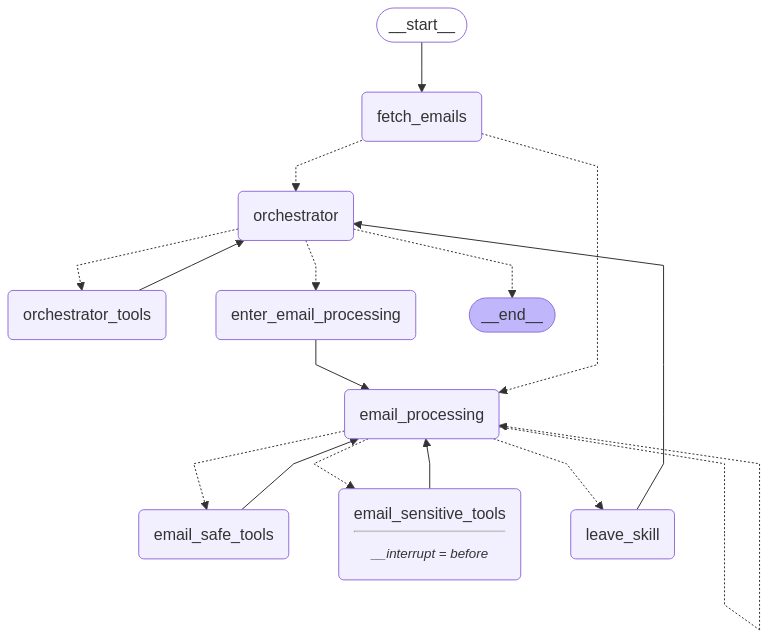

In [25]:
graph

In [26]:
# Example conversation
import uuid

thread_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id}}

tutorial_questions = [
    "Please process any new order emails.",
    # "Can you confirm the task details for the email?",
    # "Go ahead and run the experiment for that order.",
    # "Send a reply to the email confirming the order is processed.",
]

_printed = set()


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)


for question in tutorial_questions:
    events = graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = graph.get_state(config)
    while snapshot.next:
        try:
            user_input = input(
                "Do you approve of the above actions? Type 'y' to continue; "
                "otherwise, explain your requested changes.\n\n"
            )
        except:
            user_input = "y"
        if user_input.strip() == "y":
            result = graph.invoke(None, config)
        else:
            result = graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting.",
                        )
                    ]
                },
                config,
            )
        snapshot = graph.get_state(config)

================================ Human Message =================================

Please process any new order emails.
================================== Ai Message ==================================

[{'text': "I'll process the new order emails for you. I can see there is one pending order email in the queue. Let me delegate this to the EmailAgent for processing.", 'type': 'text'}, {'id': 'toolu_01Bhr5DhFj3u2JJn5VfR94vx', 'input': {'email_id': '196836fa749020a0', 'request': 'Process this email.'}, 'name': 'ToEmailProcessing', 'type': 'tool_use'}]
Tool Calls:
  ToEmailProcessing (toolu_01Bhr5DhFj3u2JJn5VfR94vx)
 Call ID: toolu_01Bhr5DhFj3u2JJn5VfR94vx
  Args:
    email_id: 196836fa749020a0
    request: Process this email.
Currently in:  email_processing
================================= Tool Message =================================

The assistant is now the Email Processing Assistant. Process the email: {"id": "196836fa749020a0", "threadId": "196836fa749020a0", "subject": "Order Ipad 

Do you approve of the above actions? Type 'y' to continue; otherwise, explain your requested changes.

 y
